In [438]:
import pandas as pd
import numpy as np
import matplotlib as plt
import scipy
from skspatial.objects import LineSegment
from enum import Enum

In [439]:
VIA_DIAM = 0.8
VIA_DRILL = 0.4
STATOR_HOLE_RADIUS = 4
TRACK_WIDTH = 0.2
TRACK_SPACING = 0.2
TURNS = 11
STATOR_RADIUS = 20
Layer = Enum('Layer', 'FRONT BACK')

In [440]:
# create a square shape
template = [(-1.5, -0.05), (1.5, -1.25), (1.5, 1.25), (-1.5, 0.05)]
# template = [(-6, -0.05), (6, -3), (6, 3), (-6, 0.05)]
# create a triangle
# template = [(-2, 0), (2, -3), (2, 3)]
# interpolate the shape using numpy

# create a circle template
# template = [(np.cos(np.deg2rad(theta)), np.sin(np.deg2rad(theta))) for theta in np.linspace(0, 360, 360)]



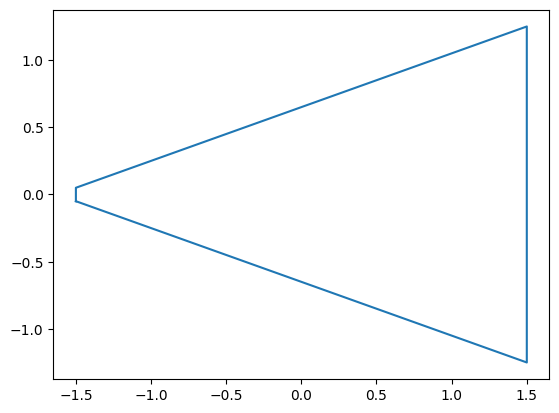

In [441]:
# plot the template shape wrapping around to the first point
plt.pyplot.plot([x for x, y in template] + [template[0][0]], [y for x, y in template] + [template[0][1]])

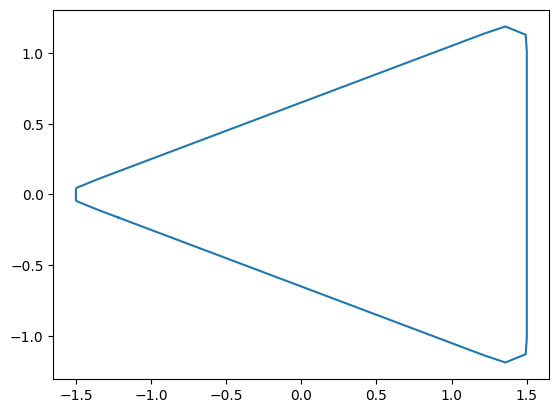

In [442]:
# apply Chaikin's algorithm to the template - corner cuttine
def chaikin(arr, iterations):
    if iterations == 0:
        return arr
    l = len(arr)
    smoothed = []
    for i in range(l):
        x1, y1 = arr[i]
        x2, y2 = arr[(i+1)%l]
        smoothed.append([0.95*x1 + 0.05*x2,0.95*y1 + 0.05*y2])
        smoothed.append([0.05*x1 + 0.95*x2,0.05*y1 + 0.95*y2])
    return chaikin(smoothed, iterations - 1)

template = chaikin(template, 2)
plt.pyplot.plot([x for x, y in template] + [template[0][0]], [y for x, y in template] + [template[0][1]])  

In [443]:
# this speeds things up dramatically as we only have to compute the line intersections once
# there are probably much faster ways of doing this - we're just doing a brute force search
# for the intersections - consult algorithms from games for inspiration...
def get_template_point_cache(template):
    # sweep a line from the origin through 360 degress times the number of turns in 1 degree increments
    # and find the intersection points with the template shape
    cache = {}
    for angle in np.arange(0, 360+2, 2):
        line = LineSegment(np.array([0, 0]), np.array([1000 * np.cos(np.deg2rad(angle)), 1000 * np.sin(np.deg2rad(angle))]))
        for i in range(len(template)):
            segment = LineSegment(np.array(template[i]), np.array(template[(i + 1) % len(template)]))
            try:
                intersection = line.intersect_line_segment(segment)
                if intersection is not None:
                    cache[angle] = (intersection, segment)
            except ValueError:
                pass
    return cache

# get the points in a coil shape
# Use reverse for bottom layer (basically flips the y coordinate so that the coil goes in the opposite direction)
# Also rotates the endpoints by 90 degress so that the exit point on the bottom layer is to the left hand side
def get_points(template, turns, spacing, layer=Layer.FRONT, cache = None):
    if cache is None:
        cache = get_template_point_cache(template)
    points = []
    for angle in np.arange(0, 360 * turns + 2, 2):
        offset = spacing * angle / 360
        if layer == Layer.BACK:
            angle = angle + 180
        intersection, segment = cache[angle % 360]
        vector = np.array(segment.point_a) - np.array(segment.point_b)
        normal = vector / np.linalg.norm(vector)
        # rotate the vector 90 degrees
        normal = np.array([-normal[1], normal[0]])
        # move the intersection point along the normal vector by the spacing
        coil_point = intersection + normal * offset
        if layer == Layer.BACK:
            points.append((coil_point[0], -coil_point[1]))
        else:
            points.append(coil_point)
    return points


In [444]:
cache = get_template_point_cache(template)

In [445]:
points_f = [(0,0)] + get_points(template, TURNS, TRACK_SPACING+TRACK_WIDTH, Layer.FRONT, cache) 
points_b = [(0,0)] + get_points(template, TURNS, TRACK_SPACING+TRACK_WIDTH, Layer.BACK, cache)

COIL_CENTER_RADIUS = STATOR_RADIUS/2+1.5

angle_A = 0
angle_B = 120
angle_C = 240

# roate the points by the required angle
def rotate(points, angle):
    return [[x * np.cos(np.deg2rad(angle)) - y * np.sin(np.deg2rad(angle)), x * np.sin(np.deg2rad(angle)) + y * np.cos(np.deg2rad(angle))] for x, y in points]

# move the points out to the distance at the requited angle
def translate(points, distance, angle):
    return [[x + distance * np.cos(np.deg2rad(angle)), y + distance * np.sin(np.deg2rad(angle))] for x, y in points]

# flip the y coordinate
def flip(points):
    return [[x, -y] for x, y in points]

# the main coils
coil_A_f = translate(rotate(points_f, angle_A), COIL_CENTER_RADIUS, angle_A)
coil_A_b = translate(rotate(points_b, angle_A), COIL_CENTER_RADIUS, angle_A)

coil_B_f = translate(rotate(points_f, angle_B), COIL_CENTER_RADIUS, angle_B)
coil_B_b = translate(rotate(points_b, angle_B), COIL_CENTER_RADIUS, angle_B)

coil_C_f = translate(rotate(points_f, angle_C), COIL_CENTER_RADIUS, angle_C)
coil_C_b = translate(rotate(points_b, angle_C), COIL_CENTER_RADIUS, angle_C)

# the opposite coils - for more power!
angle_A_opp = angle_A + 180
angle_B_opp = angle_B + 180
angle_C_opp = angle_C + 180

print(angle_A_opp, angle_B_opp, angle_C_opp)

coil_A_opp_f = translate(rotate(flip(points_f),angle_A_opp), COIL_CENTER_RADIUS, angle_A_opp)
coil_A_opp_b = translate(rotate(flip(points_b), angle_A_opp), COIL_CENTER_RADIUS,angle_A_opp)

coil_B_opp_f = translate(rotate(flip(points_f),angle_B_opp), COIL_CENTER_RADIUS, angle_B_opp)
coil_B_opp_b = translate(rotate(flip(points_b), angle_B_opp), COIL_CENTER_RADIUS, angle_B_opp)

coil_C_opp_f = translate(rotate(flip(points_f), angle_C_opp), COIL_CENTER_RADIUS, angle_C_opp)
coil_C_opp_b = translate(rotate(flip(points_b), angle_C_opp), COIL_CENTER_RADIUS, angle_C_opp)

# connect the front copper opposite coils together
common_connection_radius = STATOR_RADIUS - (TRACK_WIDTH+TRACK_SPACING) 
common_coil_connections_b = [
    (common_connection_radius * np.cos(np.deg2rad(angle)), common_connection_radius * np.sin(np.deg2rad(angle)))
    for angle in np.arange(angle_A_opp, angle_C_opp+5, 5)
]
coil_A_opp_f.append((common_connection_radius * np.cos(np.deg2rad(angle_A_opp)), common_connection_radius * np.sin(np.deg2rad(angle_A_opp))))
coil_B_opp_f.append((common_connection_radius * np.cos(np.deg2rad(angle_B_opp)), common_connection_radius * np.sin(np.deg2rad(angle_B_opp))))
coil_C_opp_f.append((common_connection_radius * np.cos(np.deg2rad(angle_C_opp)), common_connection_radius * np.sin(np.deg2rad(angle_C_opp))))

# connect coil A to it's opposite
connection_radius1 = STATOR_HOLE_RADIUS + (TRACK_SPACING)
connection_radius2 = connection_radius1 + (TRACK_SPACING+VIA_DIAM/2)
# draw a 45 degree line from coil A at connection radius 1
# then connect up to connection radius 2
# draw a 45 degree line to the opposite coil
coil_A_b.append((connection_radius1 * np.cos(np.deg2rad(angle_A)), connection_radius1 * np.sin(np.deg2rad(angle_A))))
coil_A_opp_b.append((connection_radius2 * np.cos(np.deg2rad(angle_A_opp)), connection_radius2 * np.sin(np.deg2rad(angle_A_opp))))
a_connection_b = [
    (connection_radius1 * np.cos(np.deg2rad(angle)), connection_radius1 * np.sin(np.deg2rad(angle)))
    for angle in np.arange(angle_A, angle_A+90+5, 5)
]
a_connection_f = [
    (connection_radius2 * np.cos(np.deg2rad(angle)), connection_radius2 * np.sin(np.deg2rad(angle)))
    for angle in np.arange(angle_A+90, angle_A+180+5, 5)
]
a_connection_b.append(a_connection_f[0])

coil_B_b.append((connection_radius1 * np.cos(np.deg2rad(angle_B)), connection_radius1 * np.sin(np.deg2rad(angle_B))))
coil_B_opp_b.append((connection_radius2 * np.cos(np.deg2rad(angle_B_opp)), connection_radius2 * np.sin(np.deg2rad(angle_B_opp))))
b_connection_b = [
    (connection_radius1 * np.cos(np.deg2rad(angle)), connection_radius1 * np.sin(np.deg2rad(angle)))
    for angle in np.arange(angle_B, angle_B+90+5, 5)
]
b_connection_f = [
    (connection_radius2 * np.cos(np.deg2rad(angle)), connection_radius2 * np.sin(np.deg2rad(angle)))
    for angle in np.arange(angle_B+90, angle_B+180+5, 5)
]
b_connection_b.append(b_connection_f[0])

coil_C_b.append((connection_radius1 * np.cos(np.deg2rad(angle_C)), connection_radius1 * np.sin(np.deg2rad(angle_C))))
coil_C_opp_b.append((connection_radius2 * np.cos(np.deg2rad(angle_C_opp)), connection_radius2 * np.sin(np.deg2rad(angle_C_opp))))
c_connection_b = [
    (connection_radius1 * np.cos(np.deg2rad(angle)), connection_radius1 * np.sin(np.deg2rad(angle)))
    for angle in np.arange(angle_C, angle_C+90+5, 5)
]
c_connection_f = [
    (connection_radius2 * np.cos(np.deg2rad(angle)), connection_radius2 * np.sin(np.deg2rad(angle)))
    for angle in np.arange(angle_C+90, angle_C+180+5, 5)
]
c_connection_b.append(c_connection_f[0])



180 300 420


In [446]:

def create_track(points):
    return [{"x": x, "y": y} for x, y in points]

(3.4735833333333335, 18.354750000000003, -6.13134708429227, 6.065404237330151)

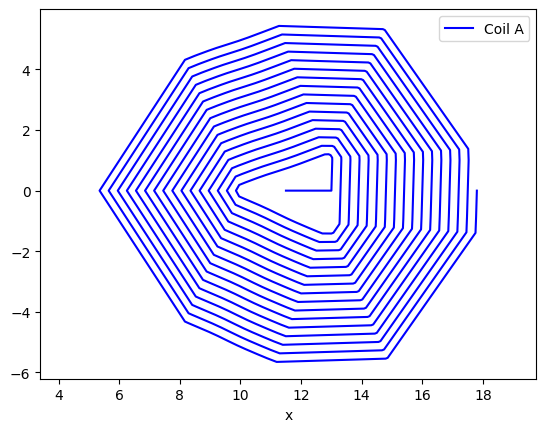

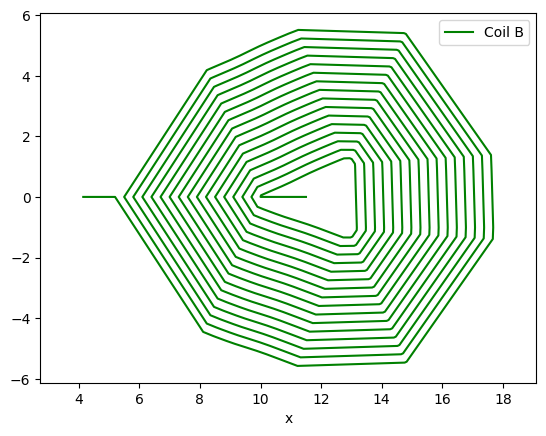

In [447]:

# dump out the results to json
json_result = {
    "parameters": {
        "trackWidth": TRACK_WIDTH,
        "statorHoleRadius": STATOR_HOLE_RADIUS,
        "viaDiameter": VIA_DIAM,
        "viaDrillDiameter": VIA_DRILL

    },
    "vias": [
        { "x": COIL_CENTER_RADIUS*np.cos(np.deg2rad(angle_A)), "y": COIL_CENTER_RADIUS*np.sin(np.deg2rad(angle_A)) },
        { "x": COIL_CENTER_RADIUS*np.cos(np.deg2rad(angle_B)), "y": COIL_CENTER_RADIUS*np.sin(np.deg2rad(angle_B)) },
        { "x": COIL_CENTER_RADIUS*np.cos(np.deg2rad(angle_C)), "y": COIL_CENTER_RADIUS*np.sin(np.deg2rad(angle_C)) },
        { "x": COIL_CENTER_RADIUS*np.cos(np.deg2rad(angle_A_opp)), "y": COIL_CENTER_RADIUS*np.sin(np.deg2rad(angle_A_opp)) },
        { "x": COIL_CENTER_RADIUS*np.cos(np.deg2rad(angle_B_opp)), "y": COIL_CENTER_RADIUS*np.sin(np.deg2rad(angle_B_opp)) },
        { "x": COIL_CENTER_RADIUS*np.cos(np.deg2rad(angle_C_opp)), "y": COIL_CENTER_RADIUS*np.sin(np.deg2rad(angle_C_opp)) },
        { "x": common_connection_radius * np.cos(np.deg2rad(angle_A_opp)), "y": common_connection_radius * np.sin(np.deg2rad(angle_A_opp)) },
        { "x": common_connection_radius * np.cos(np.deg2rad(angle_B_opp)), "y": common_connection_radius * np.sin(np.deg2rad(angle_B_opp)) },
        { "x": common_connection_radius * np.cos(np.deg2rad(angle_C_opp)), "y": common_connection_radius * np.sin(np.deg2rad(angle_C_opp)) },
        # coil A connections
        { "x": a_connection_f[0][0], "y": a_connection_f[0][1] },
        { "x": a_connection_f[-1][0], "y": a_connection_f[-1][1] },
        # coil B connections
        { "x": b_connection_f[0][0], "y": b_connection_f[0][1] },
        { "x": b_connection_f[-1][0], "y": b_connection_f[-1][1] },
        # coil C connections
        { "x": c_connection_f[0][0], "y": c_connection_f[0][1] },
        { "x": c_connection_f[-1][0], "y": c_connection_f[-1][1] },
    ],
    "silk": [
        { "x": COIL_CENTER_RADIUS*np.cos(np.deg2rad(angle_A)), "y": COIL_CENTER_RADIUS*np.sin(np.deg2rad(angle_A)), "text": "A" },
        { "x": COIL_CENTER_RADIUS*np.cos(np.deg2rad(angle_B)), "y": COIL_CENTER_RADIUS*np.sin(np.deg2rad(angle_B)), "text": "B" },
        { "x": COIL_CENTER_RADIUS*np.cos(np.deg2rad(angle_C)), "y": COIL_CENTER_RADIUS*np.sin(np.deg2rad(angle_C)), "text": "C" }
    ],
    "tracks": {
        "f": [
            create_track(points) for points in [
                coil_A_f,
                coil_A_opp_f,
                coil_B_f,
                coil_B_opp_f,
                coil_C_f,
                coil_C_opp_f,
                a_connection_f,
                b_connection_f,
                c_connection_f]
        ],
        "b": [
            create_track(points) for points in [
                coil_A_b, 
                coil_A_opp_b, 
                coil_B_b, 
                coil_B_opp_b, 
                coil_C_b, 
                coil_C_opp_b,
                common_coil_connections_b,
                a_connection_b,
                b_connection_b,
                c_connection_b]
        ]
    },
}

import json
json.dump(json_result, open("coil.json", "w"))


df = pd.DataFrame(coil_A_f, columns=['x', 'y'])
ax = df.plot.line(x='x', y='y', label='Coil A', color='blue')
ax.axis('equal')
df = pd.DataFrame(coil_A_b, columns=['x', 'y'])
ax = df.plot.line(x='x', y='y', label='Coil B', color='green')
ax.axis('equal')

# plot all three coils on the same graph
# df = pd.DataFrame(coil_A, columns=['x', 'y'])
# ax = df.plot.line(x='x', y='y', label='Coil A', color='blue')
# ax.axis('equal')
# df = pd.DataFrame(coil_B, columns=['x', 'y'])
# df.plot.line(x='x', y='y', ax=ax, label='Coil B', color='green')
# df = pd.DataFrame(coil_C, columns=['x', 'y'])
# df.plot.line(x='x', y='y', ax=ax, label='Coil C', color='red')

# df = pd.DataFrame(coil_A_opposite, columns=['x', 'y'])
# df.plot.line(x='x', y='y', ax=ax, label='Coil A Opposite', color='blue')
# df = pd.DataFrame(coil_B_opposite, columns=['x', 'y'])
# df.plot.line(x='x', y='y', ax=ax, label='Coil B Opposite', color='green')
# df = pd.DataFrame(coil_C_opposite, columns=['x', 'y'])
# df.plot.line(x='x', y='y', ax=ax, label='Coil C Opposite', color='red')

